# P1: Convolutions, Fourier Transforms, and Image Pyramids

This is the first programming assignment you will be asked to complete in the course. As we are just starting off, I have tried to keep this assignment to a manageable size (especially since many of us are working remotely and on different schedules). In the future, I will give you assignments that are a bit more open-ended, and encourage you to try different options, discover which are more effective for different tasks, and explain the decisions you have made. Since this is the beginning of the class, this assignment is a bit more formulaic.

You are *required* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. The space limit for this assignment is **4 pages maximum**. While I don't expect this limit will pose a particular challenge for this assignment, in the future I hope that it will encourage you to think more carefully about what results you choose to include and to be more clear and succinct with your writing. You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. If I ask you to compare two algorithms or approaches, you should be thorough in your comparison, using numbers in addition to qualitative explanations whenever possible. For example, at the end of P1.2.2, I ask you to compare different upsampling algorithms. Your response should include a discussion (in words) about how they are similar and different, but might also include a quantitative comparison: *by how much* do each of the upsampling algorithms differ from the original image? The [L2-norm](https://mathworld.wolfram.com/L2-Norm.html) might be meaningful to include.

Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard**. Though it would be nice if your code were cleaned up and nicely formatted/commented, we will are only likely to run your code to evaluate partial credit or unless we are skeptical for academic integrity reasons.

In [4]:
# Starter code (run this first)
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
from skimage.transform import resize
from skimage import data
from skimage.transform import pyramid_gaussian
from PIL import Image

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

## P1.1 Getting Started With Filtering

In this first assignment, you will be writing functions to generate your own image filters and using them to process images. For this problem, you should use the image I have provided. **You do not need to implement the convolution yourself.** Your version will be slower than the version built in to `scipy.signal`, which you are welcome to use. I have provided you with some simple code to get you started:

<ipython-input-4-ba693e56244e>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.asarray(img).astype(np.float)/255)[:, :, :3]


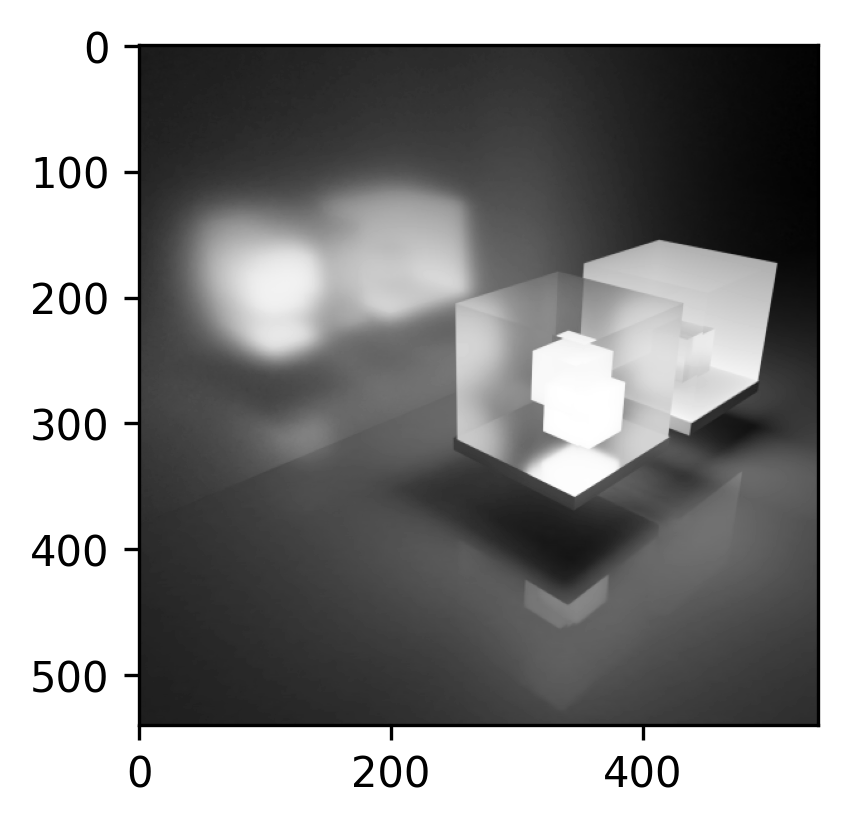

In [5]:
import scipy.signal

image = load_image("light_cubes_sm.png")[:, :, 0]
example_filter = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]
filtered_image = scipy.signal.convolve2d(
    image, example_filter, mode='same')

fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(filtered_image, cmap='gray')

None

### P1.1.1 Some Simple Filters

Define the following filters in code, which should allow you to generate the plot below, in which the filters are applied to the provided image:


$$f_a = \frac{1}{9}\begin{bmatrix} 
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1 \end{bmatrix} $$
    
$$f_b = \frac{1}{3}\begin{bmatrix} 
    0 & 0 & 0 \\
    1 & 1 & 1 \\
    0 & 0 & 0 \end{bmatrix} $$

$$f_c = \frac{1}{6}\begin{bmatrix} 
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 
    \end{bmatrix} $$
    
$$f_d = \frac{1}{3}\begin{bmatrix} 
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 
    \end{bmatrix} $$

**Plot**: Include the generated plot in your writeup, which includes all four of the images with the filter applied.

**Question**: What effect do each of the filters have on the provided image? Describe them (in one or two sentences each). Name the filter if we discussed it in class.

**Question**: Which filters are *separable*? For the separable filters, write their components parts:

In [6]:
## Base Code: modify to include the four filters.

fa = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
], dtype=np.float32)/9.0 
fb = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [0, 0, 0]
], dtype=np.float32)/3.0 
fc = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=np.float32)/6.0 
fd =  np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
], dtype=np.float32)/3.0 

if fa is None:
    raise NotImplementedError("f_a not implemented")
elif fb is None:
    raise NotImplementedError("f_b not implemented")
elif fc is None:
    raise NotImplementedError("f_c not implemented")
elif fd is None:
    raise NotImplementedError("f_d not implemented")

<ipython-input-4-ba693e56244e>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.asarray(img).astype(np.float)/255)[:, :, :3]


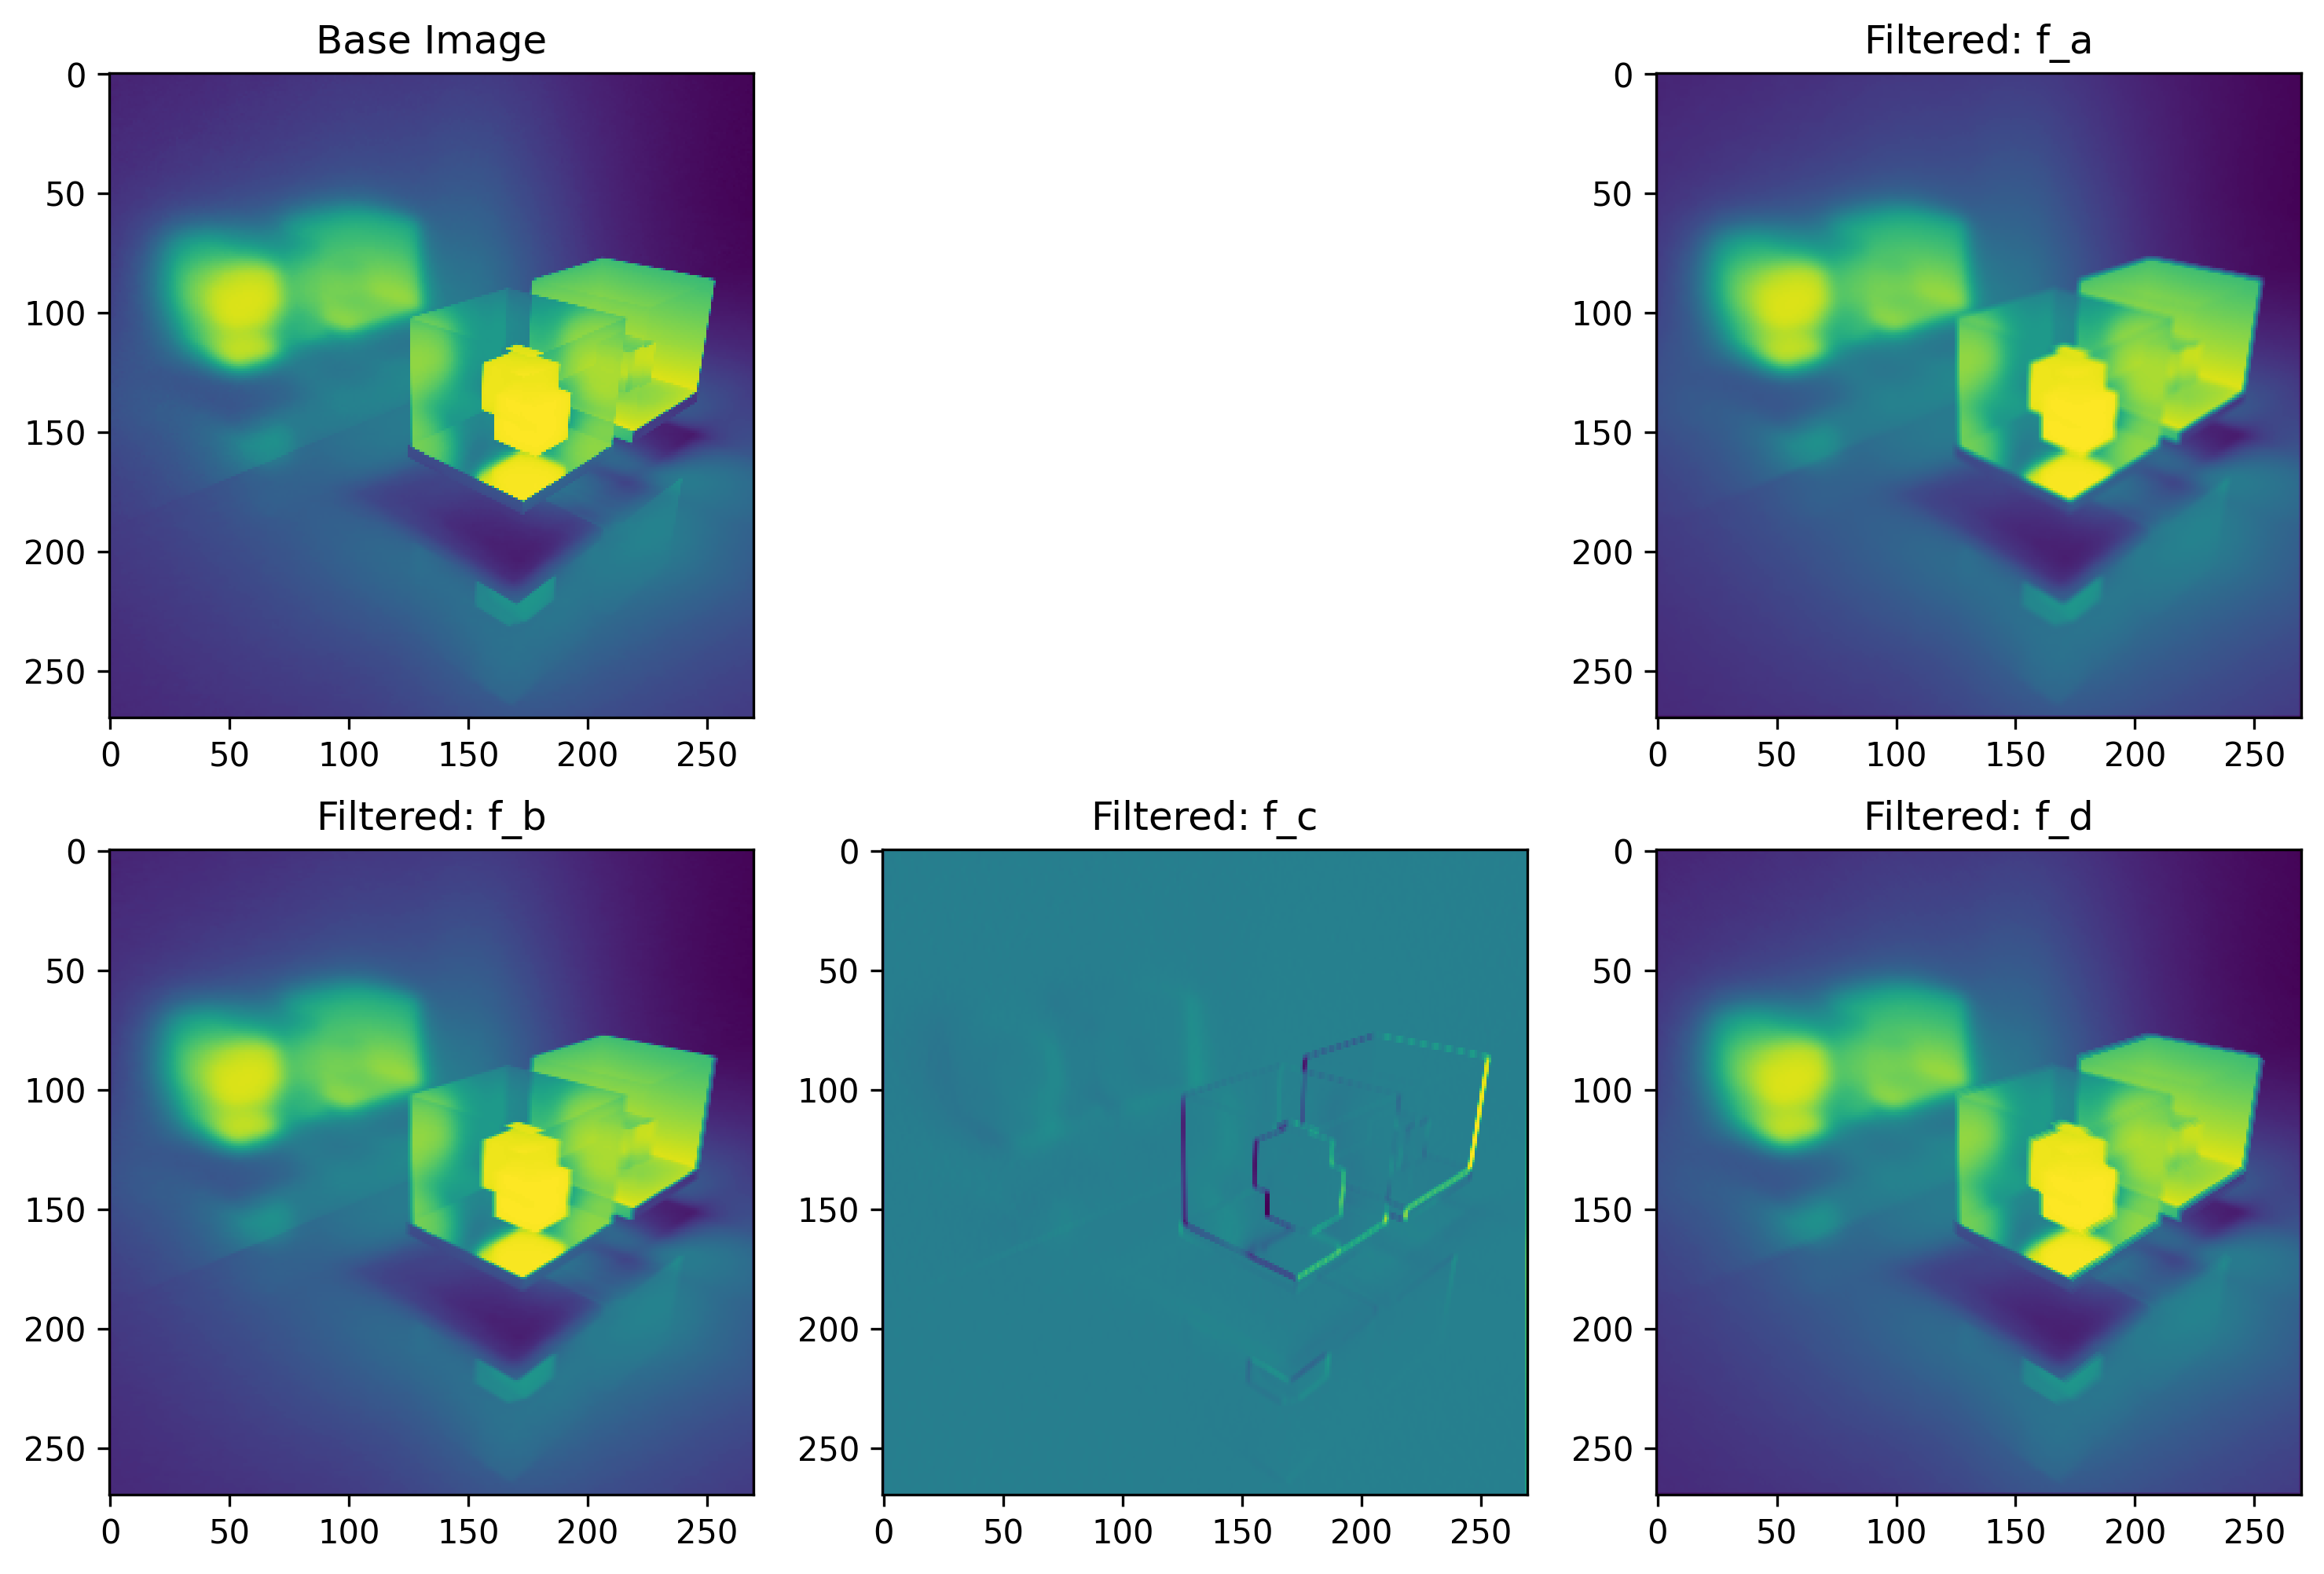

In [7]:
## Plotting code (which you should not need to modify)

image_downsampled = load_image("light_cubes_sm.png")[::2, ::2, 0]

fig = plt.figure(figsize=(12, 8), dpi=300)
plt.subplot(231)
plt.imshow(image_downsampled)
plt.title('Base Image')
plt.subplot(233)
filtered_image = scipy.signal.convolve2d(
    image_downsampled, fa, mode='same')
plt.imshow(filtered_image)
plt.title('Filtered: f_a')
plt.subplot(234)
filtered_image = scipy.signal.convolve2d(
    image_downsampled, fb, mode='same')
plt.imshow(filtered_image)
plt.title('Filtered: f_b')
plt.subplot(235)
filtered_image = scipy.signal.convolve2d(
    image_downsampled, fc, mode='same')
plt.imshow(filtered_image)
plt.title('Filtered: f_c')
plt.subplot(236)
filtered_image = scipy.signal.convolve2d(
    image_downsampled, fd, mode='same')
plt.imshow(filtered_image)
plt.title('Filtered: f_d')

None

### P1.1.2 Image Derivatives

**Plots:** Implement the image derivatives $I_x$ and $I_y$ using the vertical and horizontal Sobel filters. Apply these to the provided image and include plots for each.

**Plots:** Using $I_x$ and $I_y$, compute the image gradient magnitude and angle (recall that the gradient is a vector $\nabla I = [I_x, I_y]$, which has a magnitude and gradient). Include figures of both.

**Question:** Using a finite-difference method (see the lecture notes for how we derived the Sobel filters), derive a filter for the image Laplacian: $$\nabla^2 I = \frac{\partial^2 I}{\partial x^2} + \frac{\partial^2 I}{\partial y^2}$$ and include the definition of your Laplacian filter in your writeup.

**Plot:** Compute and plot the Laplacian of the provided image. 

**Be sure to title your plots so that it is clear which plot is which.**

*Note*: Be attentive with your color schemes for your plots. When plotting image derivatives, using a color map like `gray` or `viridis` assigns a middle value to a non-recognizable color somewhere in the middle of the spectrum. You might want to look into a *diverging color map* like `PiYG` and set the `vmin` and `vmax` args for `imshow` so that the zero-crossing is a *special value* of pure white. See the [matplotlib guide on colormaps](https://matplotlib.org/3.3.0/tutorials/colors/colormaps.html) for more details.

<ipython-input-4-ba693e56244e>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.asarray(img).astype(np.float)/255)[:, :, :3]


Text(0.5, 1.0, 'Vertical Sobel filter')

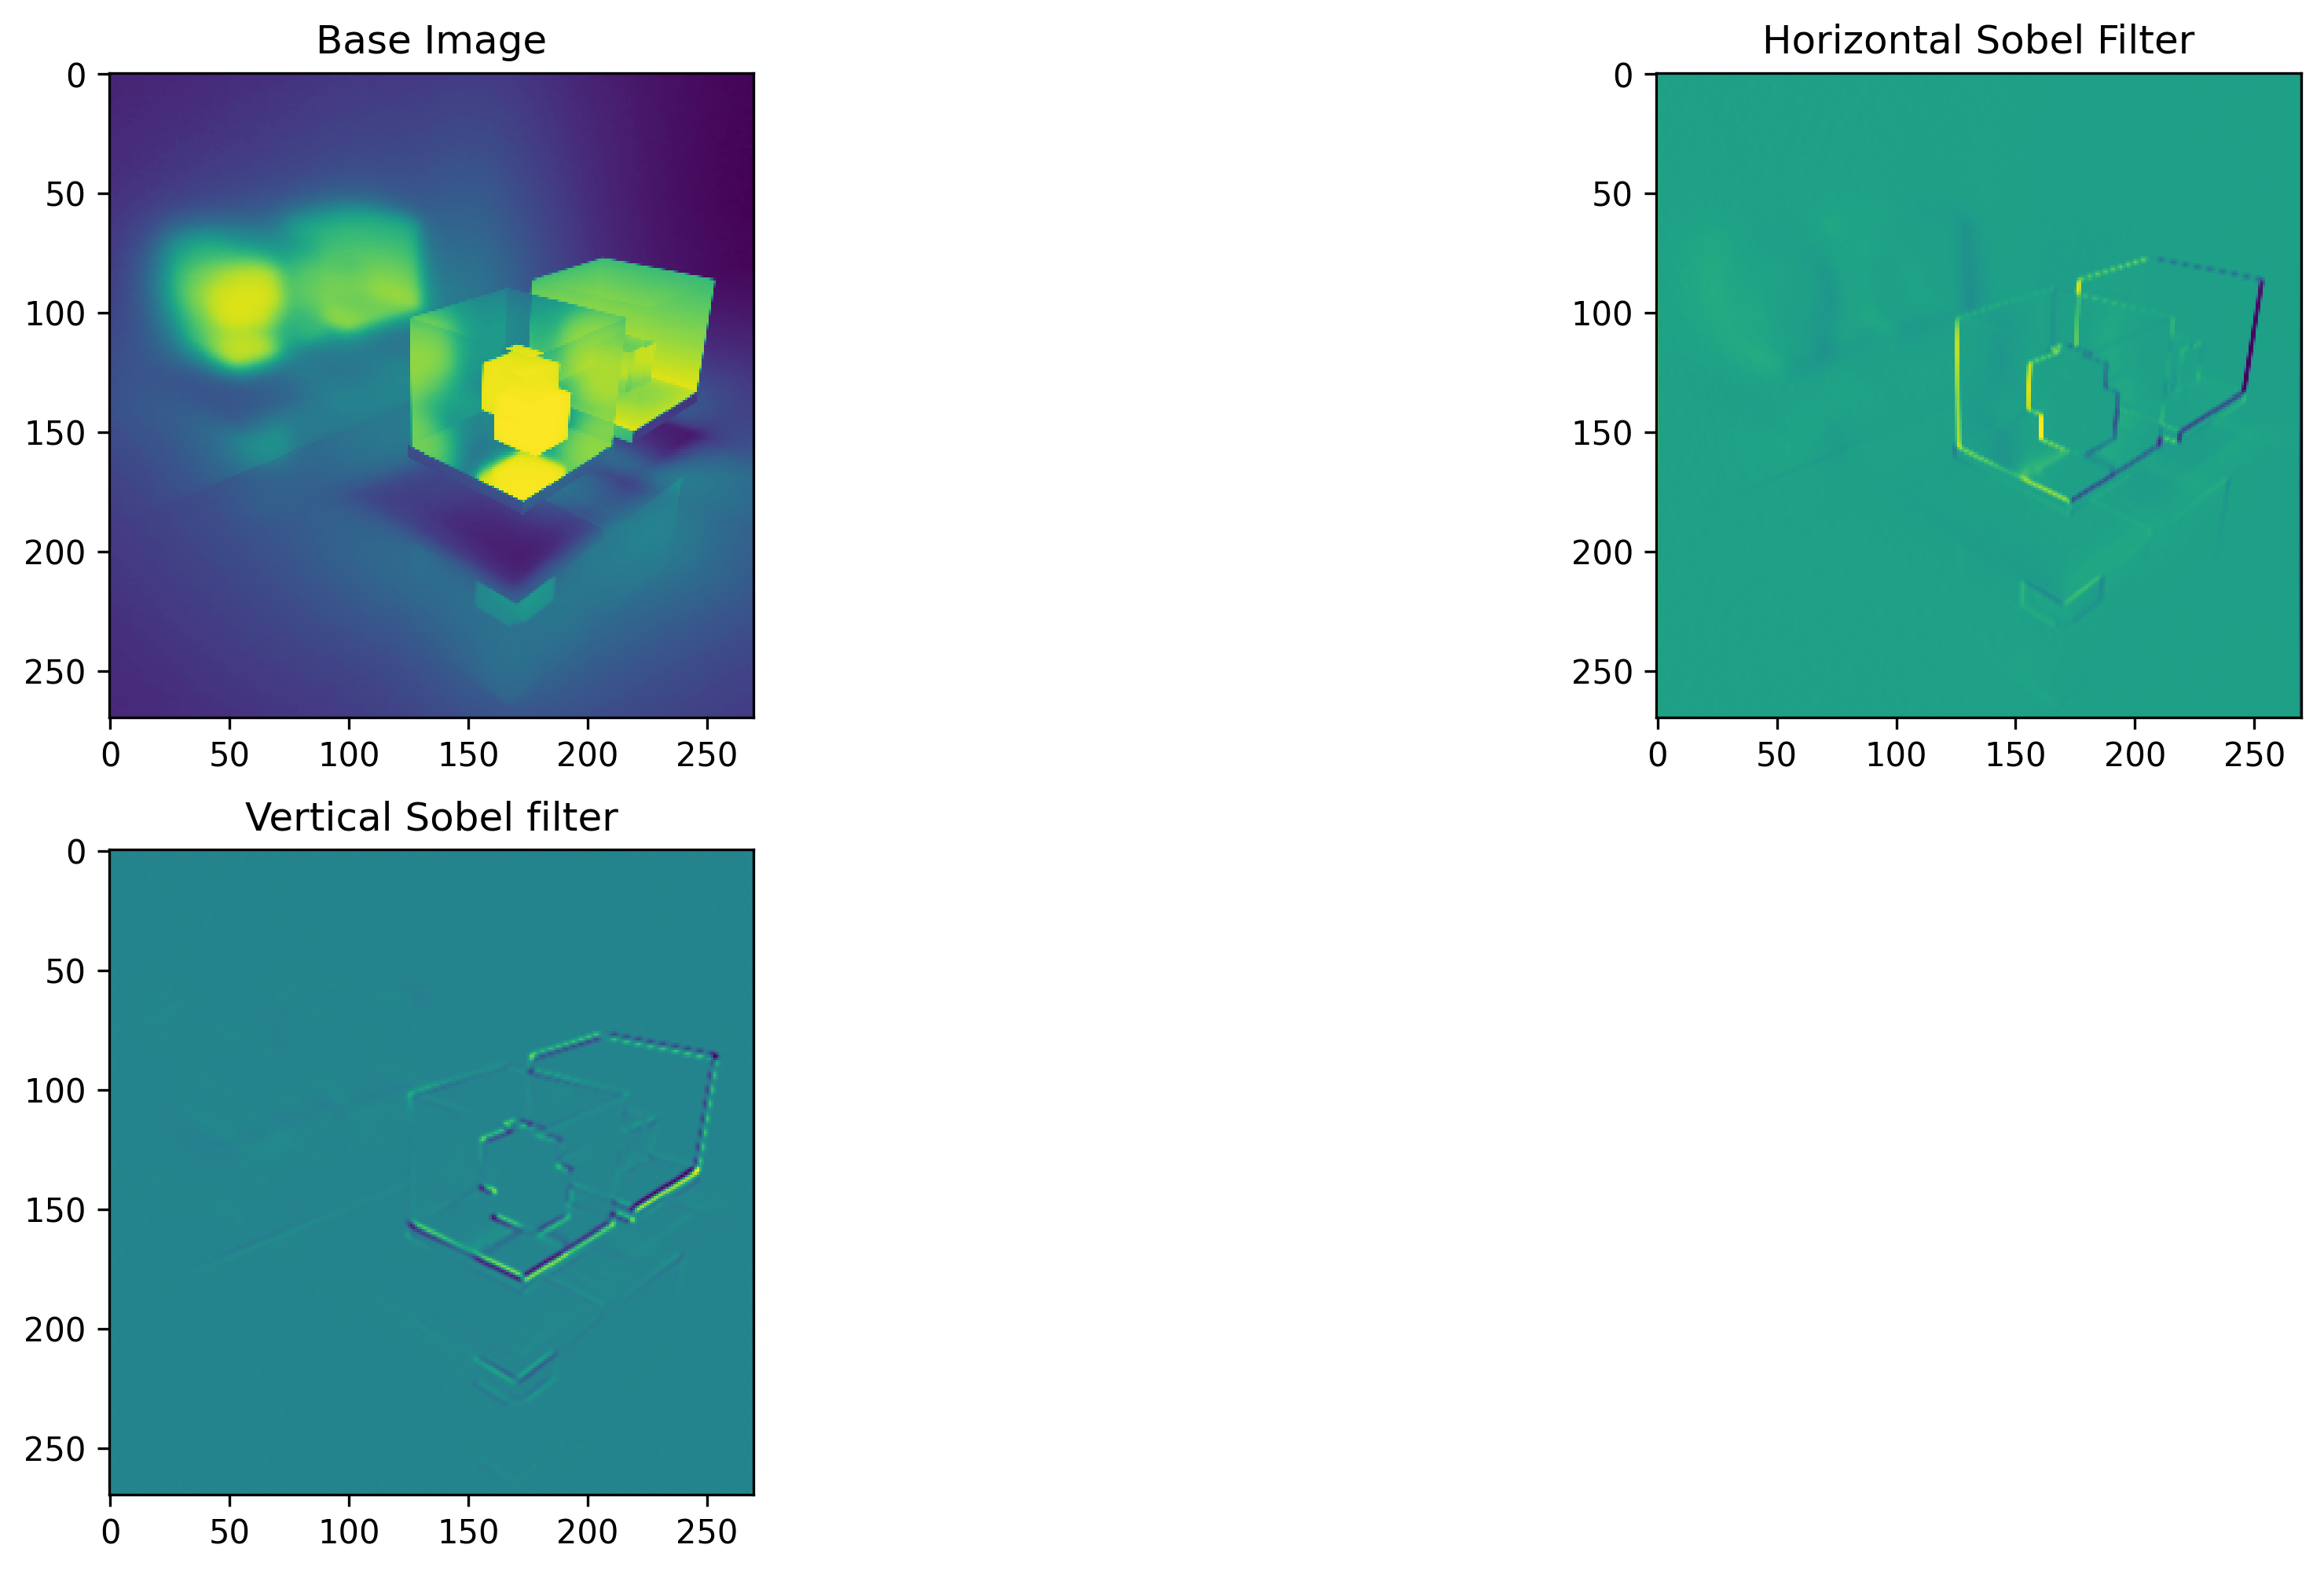

In [8]:
## plot 1 (implement image derivatives ix and Iy using sobel filters)
########################################
image_downsampled = load_image("light_cubes_sm.png")[::2, ::2, 0]
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.subplot(231)
plt.imshow(image_downsampled)
plt.title('Base Image')

## Horizontal filter
hf = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)
##Vertical filter
vf = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
], dtype=np.float32)


plt.subplot(233)
filtered_image = scipy.signal.convolve2d(
    image_downsampled, hf, mode='same')
plt.imshow(filtered_image)
plt.title('Horizontal Sobel Filter')

plt.subplot(234)
filtered_image = scipy.signal.convolve2d(
    filtered_image, vf, mode='same')
plt.imshow(filtered_image)
plt.title('Vertical Sobel filter')





In [1]:
## PLOT2 Compute the image gradient magnitude
########################################
image_downsampled = load_image("light_cubes_sm.png")[::2, ::2, 0]
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.subplot(231)
plt.imshow(image_downsampled)
plt.title('Base Image')

## Horizontal sobel
hf = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)

Ix = scipy.signal.convolve2d(
    image_downsampled, hf, mode='same')

##Vertical filter
vf = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
], dtype=np.float32)

plt.subplot(233)

Iy = scipy.signal.convolve2d(
    image_downsampled, vf, mode='same')
## gradient of image
Gradient = np.sqrt(Iy**2 + Ix**2)

plt.imshow(Gradient)
plt.title('Gradient')
## Angle of image

imageAngle = np.arctan2(Iy,Ix)
plt.subplot(234)
plt.imshow(imageAngle)
plt.title('Angle Image')

## Laplacian filter
lp = np.array([

  [0, -1, 0],

  [-1, 4, -1],

  [0, -1, 0]

], dtype=np.float32)
LapImage = scipy.signal.convolve2d(
    image_downsampled, lp, mode='same')

plt.subplot(232)
plt.imshow(LapImage)
plt.title('Laplacian Image')

NameError: name 'load_image' is not defined

### P1.1.3 Gaussian Filtering

Compute a discrete Gaussian Filter using the provided function `get_gaussian_filter` defined below.

**Plots:** Compute filters for three different $\sigma$ values and apply them to your image (you should be able to see the difference in amount of blur between them). Plot the filters alongside the images they are used to generate (one subplot for each). Be sure that the filter width is large enough that it does not meaningfully impact the output compared to the $\sigma$ of the filter.

**Question:** What would happen if the filter width were too small compared to $\sigma$? You may answer in words, though a figure would also be acceptable.

In class, we defined a `3x3` Gaussian filter as follows:
$$g = \frac{1}{16}\begin{bmatrix} 1 & 2 & 1 \\ 2 & 4 & 2 \\ 1 & 2 & 1 \end{bmatrix}$$
**Question:** What is the $\sigma$ of this filter?

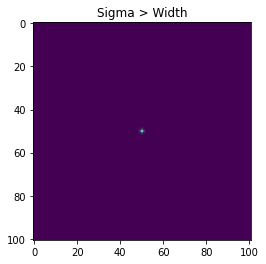

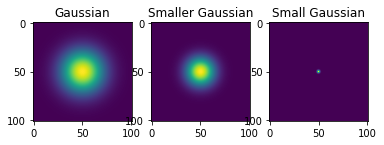

In [35]:
def get_gaussian_filter(n, sigma=1):
    n = 2 * (n//2) + 1
    h = (n + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Take the gaussian
    g = np.exp(-d_sq/2/(sigma**2))
    # Normalize
    g = g/g.sum().sum()
    return g

plt.imshow(get_gaussian_filter(101, sigma=.5))
plt.title("Sigma > Width")
plt.show()

plt.subplot(234)
plt.imshow(get_gaussian_filter(101, sigma=15))
plt.title('Gaussian')
plt.subplot(235)
plt.imshow(get_gaussian_filter(101, sigma=10))
plt.title('Smaller Gaussian')
plt.subplot(236)
plt.imshow(get_gaussian_filter(101, sigma=1))
plt.title('Small Gaussian')

None

### P1.1.4 Derivative of Convolution

In class, we discussed the derivative of convolution theorem:

$$ \frac{\partial }{\partial x} (f * h) = \frac{\partial f}{\partial x} * h $$

**Plots**: Show empirically that this theorem holds on your image: computing both the left and right hand side and comparing them to one another. You may find it helpful to include any intermediate products in your plots.

*Note:* to compute the partial deratives, you should use the Sobel filters you defined and implemented above.

Text(0.5, 1.0, '(derivative * gaussian) * image')

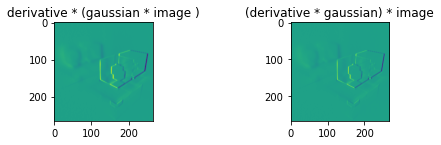

In [51]:
## derivative * (gaussian * image ) = (derivative * gaussian) * image


##dx filter
dx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)

## gaussian filter
gauss = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32)/16

plt.subplot(231)
# (gaussian * image )
gaussImage = scipy.signal.convolve2d( 
    image_downsampled, gauss, mode='valid')
# derivative x * (gaussian * image ) 
leftImage = scipy.signal.convolve2d(
    gaussImage, dx, mode='valid')

plt.imshow(leftImage)
plt.title('derivative * (gaussian * image )')

# (derivative * gaussian)
ex = scipy.signal.convolve2d( 
    dx, gauss, mode='same')
# (derivative * gaussian) * image
RightImage = scipy.signal.convolve2d(
    image_downsampled, ex, mode='valid')

plt.subplot(233)
plt.imshow(RightImage)
plt.title('(derivative * gaussian) * image')


## P1.2 Image Upsampling

In class, we discussed *Image Upsampling*, the process of making larger images from smaller ones by interpolating between the discrete pixel values. Upsampling (and the interpolation process) will become quite relevant in a few weeks when we discuss image warping. As such, you should make sure that these functions are well-documented and you can easily reuse them: **you will want to have them to serve as starter code for the next problem sets**.

### P1.2.1 Upsampling Kernels

In this part of the problem, you will be asked to upsample an image using some of the interpolation strategies we discussed in class. I have provided an image and its downsampled version.

Your task is to complete the `interp_STRATEGY` functions I have provided below. For each function, you are asked to provide the original image and the `new_x` and `new_y` values at which you would like the new value. I have provided you with the `upsample_image` function that will use the interpolation function you will create. Make sure you understand what is going on in that function. In particular, I have used the `np.ndenumerate` function to loop through the numpy arrays and the `image[y, x]` convention (since the image is stored as `[rows, columns]`).

I recommend that you begin by implementing an interpolation function that works on a 1-dimensional signal before attempting to upsample a 2-dimensional image. Feel free to include plots of the 1D interpolation if you feel it is helpful to your writeup.

**Task:** Implement the two different interpolation strategies listed below: *bilinear*, and *bicubic* (See Ch 3.5 in Szeliski for a discussion of these strategies and, actually, Wikipedia's page on [Bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation) also has a good discussion.). Note that *bicubic* interpolation requires selecting a *boundary condition* for points outside the image; feel free to choose a "zero" boundary condition: i.e. return 0 whenever a point outside the image is requested. After interpolation, one way of verifying that it has worked is to confirm that re-downsampling your upsampled image recovers your uninterpolated image for each upsampling function.

**Plots:** Include plots showing the upsampled image and the difference between the original and upsampled images for each of the three strategies.

<ipython-input-165-ba693e56244e>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.asarray(img).astype(np.float)/255)[:, :, :3]


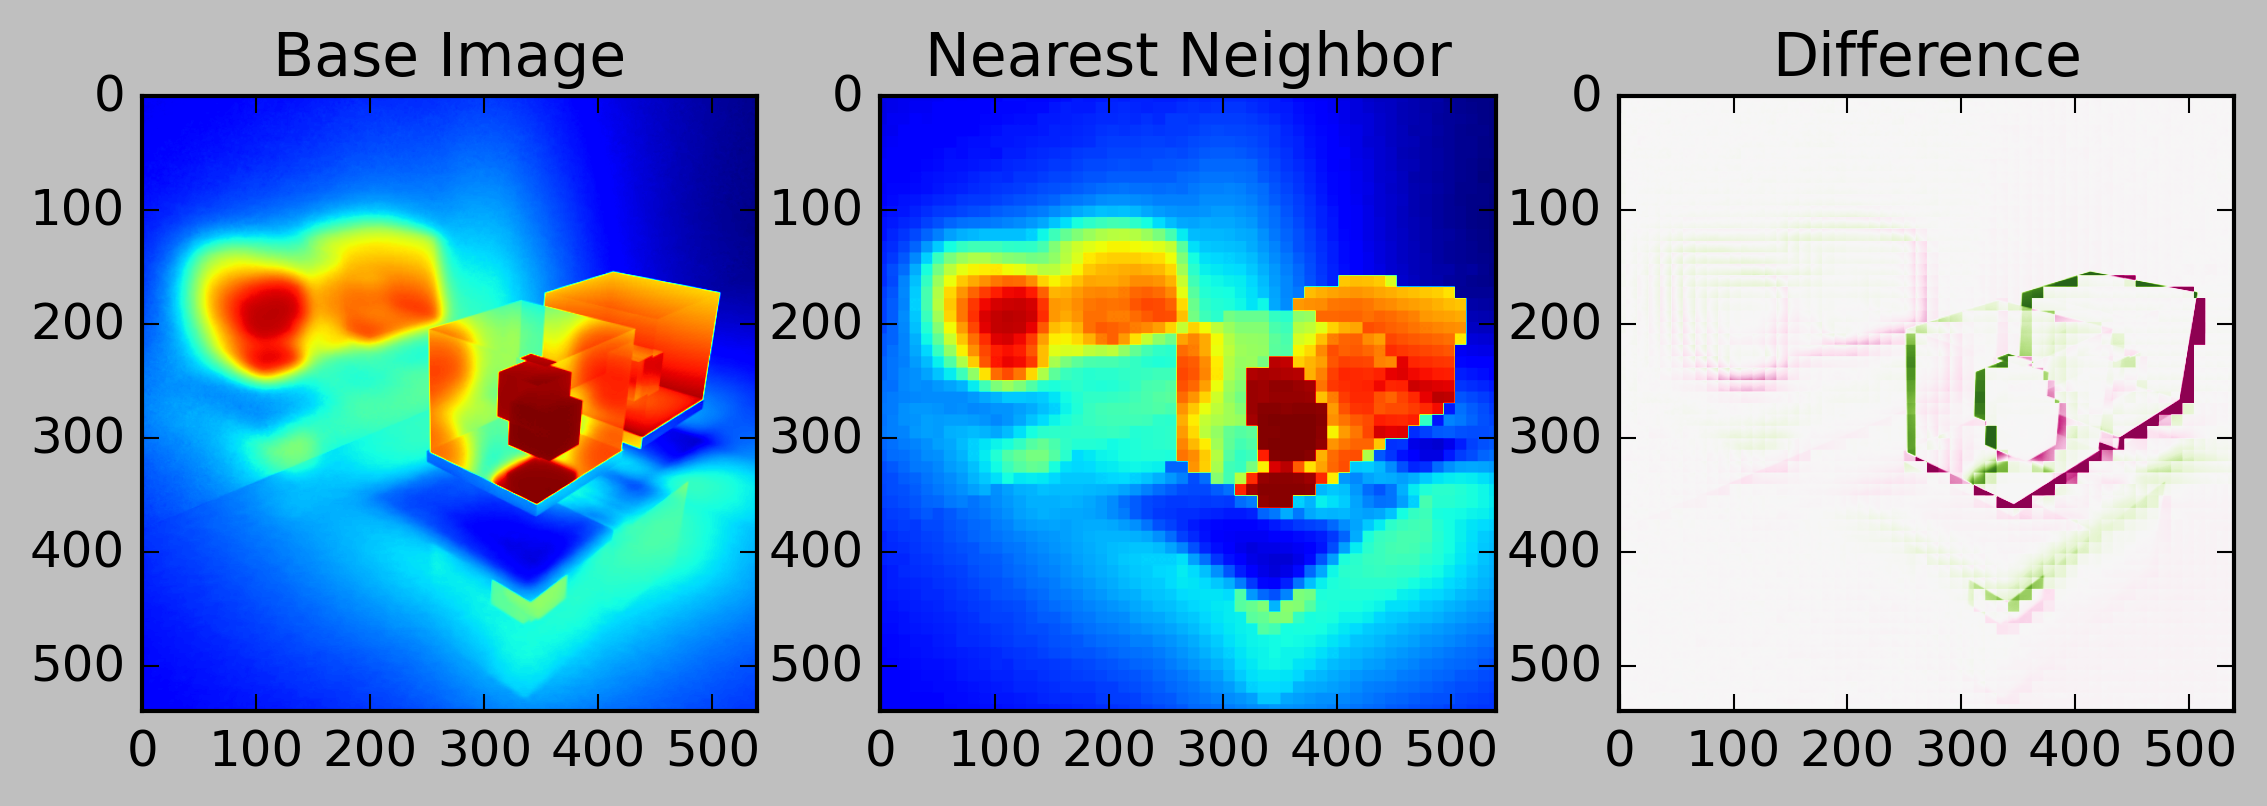

NotImplementedError: 

In [186]:
def upsample_image(image, target_shape, interp_fn):
    # Initialize the upsampled image
    image_up = np.zeros(target_shape)
    
    # Define the new coordinates (using the [y, x] convention
    # since image matrices are defined [row, column])
    new_xs = np.linspace(0, image.shape[1]-1, 
                         target_shape[1], endpoint=True)
    new_ys = np.linspace(0, image.shape[0]-1, 
                         target_shape[0], endpoint=True)
    
    # Loop through coordinates and set the image values
    for ix, new_x in np.ndenumerate(new_xs):
        for iy, new_y in np.ndenumerate(new_ys):
            image_up[iy, ix] = interp_fn(image, new_x, new_y)
            
    return image_up

def plot_upsampling(image, interp_fn, title):
    image_sm = image[::10, ::10]
    image_up = upsample_image(image_sm, image.shape, interp_fn)
    fig = plt.figure(figsize=(9, 3), dpi=300)
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Base Image')
    plt.subplot(132)
    plt.imshow(image_up)
    plt.title(title)
    plt.subplot(133)
    plt.imshow(image - image_up, cmap='PiYG', vmin=-0.5, vmax=0.5)
    plt.title('Difference')
    plt.show()

def interp_nn(image, new_x, new_y):
    nx = int(round(new_x)) ## round the x,y value up or down.
    ny = int(round(new_y))
    if nx < 0: ## bounds condition, if x or y < 0 set to 0
        nx = 0
    if ny < 0:
        ny = 0

    return image[ny, nx]
    
def interp_bilinear(image, new_x, new_y):
   # new_x = int(round(new_x))
   # new_y = int(round(new_y))
    ## boundary conditions, defualt to 0
  #  if(new_x-1 <= 0){
    #    new_x = 0;
   # }
  #  x1 = new_x-1
 #   x2 = x1+1
   # y1 = new_y-1
  #  y2 = y1 + 1
   # 
    #tl = (x1-new_x) / (new_y-y1) * image[y1][x1]
    #tr = (x2-new_x) / (new_y-y1) * image[y1][x2]
  #  bl = (new_x-x1) / (new_y-y2) * image[y2][x1]
 #   br = (new_x-x2) / (new_y-y2) * image[y2][x2]
#   return tl + tr + bl + br
    raise NotImplementedError()

    
def interp_bicubic(image, new_x, new_y):
    raise NotImplementedError()

# An example use of the upsample_image function
image = load_image("light_cubes_sm.png")[:, :, 0]

# Plot the different upsampling functions
plot_upsampling(image, interp_nn, 'Nearest Neighbor')
plot_upsampling(image, interp_bilinear, 'Bilinear')
plot_upsampling(image, interp_bicubic, 'Bicubic')

In [ ]:
# Inspecting the Frequency Space Representation

image = load_image("light_cubes_sm.png")[:, :, 0]
image_sm = image[::10, ::10]

fig = plt.figure(figsize=(12, 6), dpi=300)

ax = plt.subplot(1, 3, 1)
ax.imshow(image_sm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Img')

ax = plt.subplot(1, 3, 2)
ax.imshow(np.abs(np.fft.fft2(image_sm)))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('abs(Frequency Space Img)')

ax = plt.subplot(1, 3, 3)
ax.imshow(np.log(np.abs(np.fft.fft2(image_sm)) + 1e-10))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('log(abs(Frequency Space Img))')

None

**Question:** (1-3 sentences) Using the ideas discussed in class (the Nyquist Limit and the Wagon Wheel Effect) explain (in words) why the four corners of the frequency-space image are where most of the intensity is located. *Hint*: for a discrete Fourier Transform, there are no explicitly "negative frequencies". How are frequencies above the Nyquist Limit related to  the "negative frequencies" we would expect to see when taking a continuous Fourier Transform?

In the next code block, I have provided you with a function that upsamples an image using 'zero-padding' in frequency space, something you will explore theoretically in your quiz. The function converts the image to frequency space, 'pads' the image with zeros (equivalent to adding new "high frequency" terms that have zero amplitude), and then converts the image back. Run the code below and look at the result:

In [ ]:
# Upsampling with Fourier Transforms
def upsample_image_fft(image, target_shape):
    """Upsample an image using zero-padding in frequency space."""
    # Some helper definitions
    sx_sm, sy_sm = image.shape
    sx, sy = target_shape
    
    # Transform and 'shift' the image
    img_fft = np.fft.fft2(image)
    img_fft = np.fft.fftshift(img_fft, axes=(0, 1))
    
    # Initialize the new frequency space image
    img_up_fft = np.zeros(target_shape, dtype=np.complex)

    # Put the smaller frequency space image in the 
    # middle of the new frequency space image
    img_up_fft[(sx-sx_sm)//2:(sx+sx_sm)//2,
               (sy-sy_sm)//2:(sy+sy_sm)//2] = img_fft
    
    # Shift back and un-transform (inverse FFT)
    img_up_fft = np.fft.ifftshift(img_up_fft, axes=(0, 1))
    img_up = np.fft.ifft2(img_up_fft)
    
    # Images are purely real (compensates for numerical artifacts)
    img_up = np.real(img_up)
    return img_up
    
image = load_image("light_cubes_sm.png")[:, :, 0]
image_sm = image[::10, ::10]
image_up_fft = upsample_image_fft(image_sm, image.shape)

fig = plt.figure(figsize=(12, 6), dpi=300)

ax = plt.subplot(1, 3, 1)
ax.imshow(image)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Original Image')

ax = plt.subplot(1, 3, 2)
ax.imshow(image_sm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Small Image')

ax = plt.subplot(1, 3, 3)
ax.imshow(image_up_fft)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('FFT Upsampled Image')

None

**Plots:** Compare the frequency-space representations of the FFT upsampled image to the upsampled images you generated in P1.2.1 and to the frequency-space representation of the original image by plotting them side-by side (for a total of 5 frequency-space images). You may also find it helpful to include plots of the `np.log(np.abs(fourier_representation))` for each of the images so that it is easier to visually inspect the higher-frequency regions.

**Question:** In 1-2 sentences, explain why the FFT upsampled image appears to have oscilating patterns? *Hint:* think about the higher frequency components that the upsampled image does not have. What frequency components are required (and missing) to make a sharp edge?

**Question:** In 3-6 sentences, describe how the frequency-space representations of the different upsampled images are different from one another. How is the FFT upsampled image particular different from the others? Is this behavior expected?

## P1.3 Hybrid Images (Contest)

In class, we discussed *hybrid images* in which the low-frequency components of one image are added to the high-frequency components of another and added together to make an image that looks like their different components up close and from far away. See the [Hybrid Images paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) for more details about the original research. 

Here, you are asked to implement a simplified version of the Hybrid Images work. We will vote as a class on the different submissions and pick out our favorites (though the vote will have no consequence on your grade). **If you would like me not to include your submision in the "contest" please say so in your writeup.**

We discussed some filtering concepts in class, but as a refresher, one can implement a low-pass filter using a Gaussian Blur, applying a gaussian filter $g_\sigma$ to the image via a convolution operation (thereby reducing the high-frequency components of the image). The filters we are discussing here are *linear*, which means that we can implement a high-pass filter by subtracting a low-passed image from the original image: e.g., convolve with a filter $1 - g_\sigma$.

Steps for implementing the hybrid image:

1. Choose two images you intend to combine to form your *hybrid image*; one will add the low-frequencies $I_l$ and one will add the high frequencies $I_h$.
2. Implement a low-pass filter (using a Gaussian Blur: $g_{\sigma_1}$) and a high-pass filter (1 minus a Gaussian Blurred image: $1 - g_{\sigma_2}$). Apply the low-pass filter to image $I)l$ and the high-pass filter to the other $I_h$ and average the two together to produce your *hybrid image*. You may need to experiment with parameters $\sigma_1$ and $\sigma_2$.

**Plots:** Include plots of the original two images, the low-passed image, the high-passed image, and the combined hybrid image (a total of 5 images).

**Task:** Following the procedure we discussed in class, **generate a Gaussian image pyramid from your newly constructed hybrid image**. Combine all images into a single image as follows (though without the annotations) and include it in your writeup: <img src="image_pyramid.png" alt="Image Pyramid" style="width: 400px;"/>

<ipython-input-165-ba693e56244e>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.asarray(img).astype(np.float)/255)[:, :, :3]


ValueError: could not broadcast input array from shape (256,256) into shape (256,256,3)

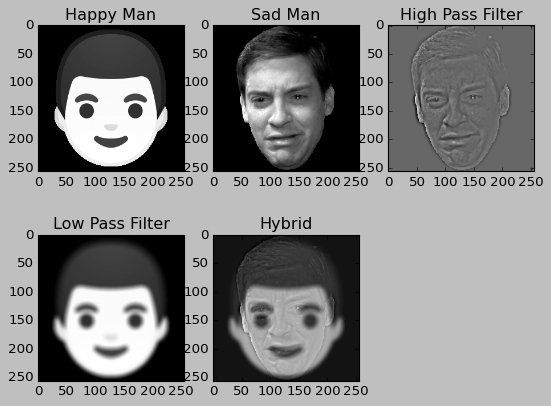

In [170]:
#1 Plot include orignal two image, low passed image, and hybrid image
happyImage = load_image("happy.png")[:, :, 0]
sadImage = load_image("sad.png")[:, :, 0]

# normal images
plt.subplot(231)
plt.imshow(happyImage, cmap='gray')
plt.title('Happy Man')

plt.subplot(232)
plt.imshow(sadImage, cmap='gray')
plt.title('Sad Man')


## high pass filter: 1- gaussin blur
lFilter = get_gaussian_filter(10, sigma=8)


highP = scipy.signal.convolve2d(
    sadImage, lFilter, mode='same')


highpass = sadImage-highP

plt.subplot(233)
plt.imshow(highpass, cmap='gray')
plt.title('High Pass Filter')
 


    
# low pass filter: gaussian blur
lFilter = get_gaussian_filter(10, sigma=7)



lowpass = scipy.signal.convolve2d(
    happyImage, lFilter, mode='same')

plt.subplot(234)
plt.imshow(lowpass, cmap='gray')
plt.title('Low Pass Filter')

hybrid = (lowpass + highpass)/2
plt.subplot(235)
plt.imshow(hybrid, cmap='gray')
plt.title('Hybrid')



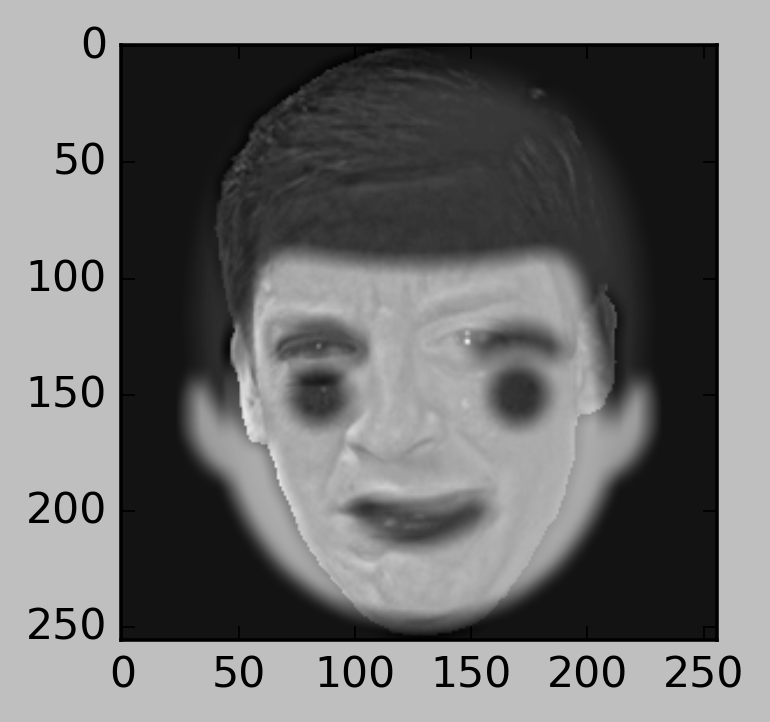

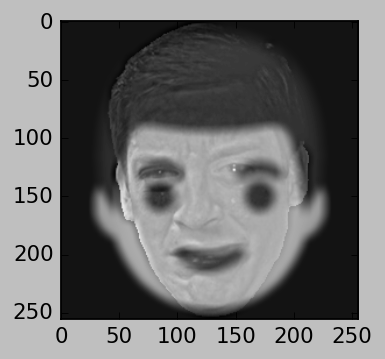

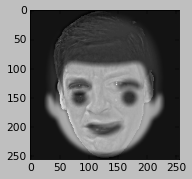

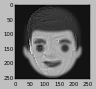

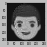

In [182]:

#from scipy documentation

image = hybrid
fig = plt.figure(figsize=(3, 3), dpi=256)
plt.imshow(image, cmap='gray')
fig = plt.figure(figsize=(3, 3), dpi=128)
plt.imshow(image, cmap='gray')
fig = plt.figure(figsize=(3, 3), dpi=64)
plt.imshow(image, cmap='gray')
fig = plt.figure(figsize=(3, 3), dpi=32)
plt.imshow(image, cmap='gray')
fig = plt.figure(figsize=(3, 3), dpi=16)
plt.imshow(image, cmap='gray')
fig = plt.figure(figsize=(3, 3), dpi=8)
plt.imshow(image, cmap='gray')